### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=1
date_time='2017-02-20_2302' # specify the date and time of the run in the format YYYY-MM-DD_HHMM
run_dir=run_dir_prefix+date_time
runfile='Exp_%s_run_%s.npz' % (date_time, run) # location of the experiment results
config, dbn_dict = MDBN.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [2, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [2],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [2, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'p': 1.0,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'persistent': False},
 u'uuid': u'9bbefc05

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

In [7]:
import utils
real_set, _ = utils.load_n_preprocess_data(datafiles['GE'],datadir=data_dir)

#### Compute the joint layer components

In [8]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

In [9]:
#dbn_output = dbn_dict['GE'].get_output(theano.shared(np.zeros(real_set.get_value().shape,
#                                                                        dtype=theano.config.floatX),borrow=True))
dbn_output = np.zeros((real_set.get_value().shape[0],40),dtype=theano.config.floatX)

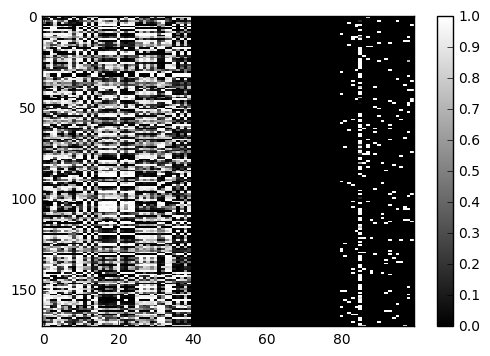

In [10]:
joint_layer = np.hstack((dbn_output_list[0],dbn_output,dbn_output_list[2]))
#joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

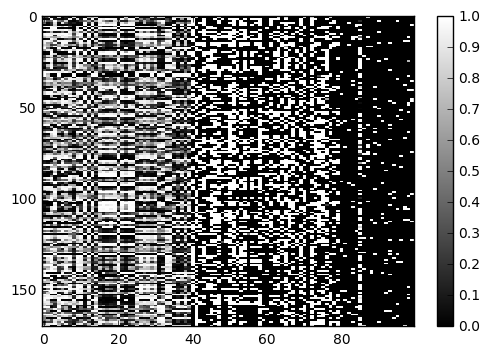

In [11]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [12]:
top_output = dbn_dict['top'].get_output(joint_layer)

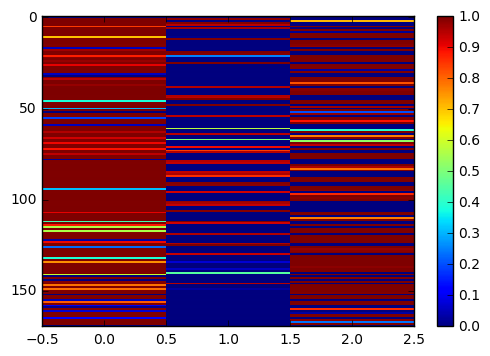

In [13]:
plt.imshow(top_output, interpolation='none')
plt.axis('tight')
plt.colorbar()

In [14]:
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]
reload(rbm)
sampled_hidden_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True))

 ... computing sample 0


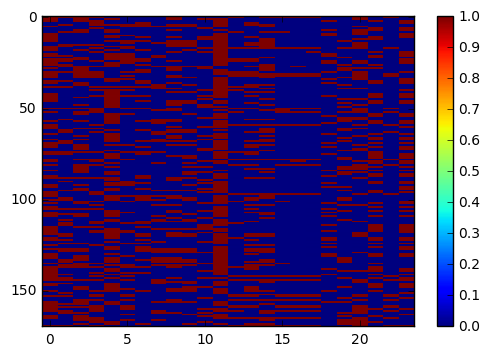

In [15]:
plt.imshow(sampled_hidden_layer[0],interpolation='none')
plt.axis('tight')
plt.colorbar()

### Gibbs sampling of the top layer

In [16]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]

In [17]:
h1 = theano.tensor.matrix('h1')
rec_joint_layer = top_dbn_rbm0.sample_v_given_h(h1)

In [18]:
rec_joint_fn = theano.function([h1], rec_joint_layer)

In [19]:
sampled_joint_layer = rec_joint_fn(sampled_hidden_layer[0])

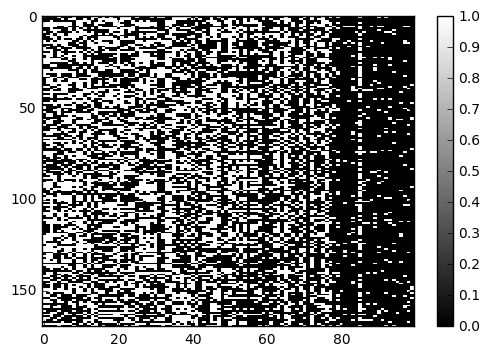

In [20]:
plt.imshow(sampled_joint_layer[2], cmap='gray',interpolation='none')
plt.axis('tight')
plt.colorbar()

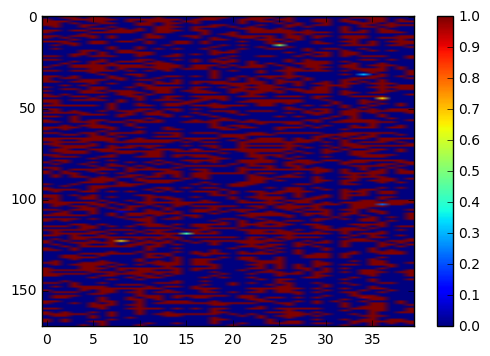

In [21]:
plt.imshow(np.sqrt(np.square(real_joint_layer[:,40:80]-sampled_joint_layer[2][:,40:80])))
plt.axis('tight')
plt.colorbar()

### Propagate down with ancestral sampling

In [22]:
dbn_rbm1 = dbn_dict['GE'].rbm_layers[1]

In [23]:
h1 = theano.tensor.matrix('h1')
hid_layer = dbn_rbm1.sample_v_given_h(h1)

In [24]:
hid_fn = theano.function([h1], hid_layer)

In [26]:
_, _, sample_hid_layer = hid_fn(sampled_joint_layer[2][:,40:80])

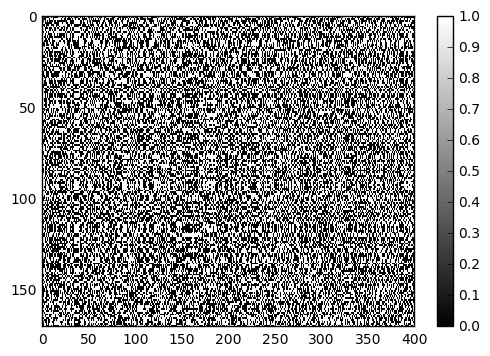

In [27]:
plt.imshow(sample_hid_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [28]:
dbn_rbm0 = dbn_dict['GE'].rbm_layers[0]

In [29]:
vis_layer = dbn_rbm0.sample_v_given_h(h1)
vis_fn = theano.function([h1], vis_layer)

In [30]:
_, _, sample_vis_layer = vis_fn(sample_hid_layer)

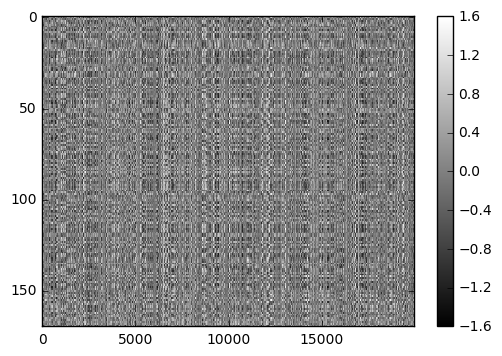

In [47]:
plt.imshow(sample_vis_layer,interpolation='none',cmap='gray',clim=(-1.6,1.6))
plt.axis('tight')
plt.colorbar()

### Compare reconstructed and actual data

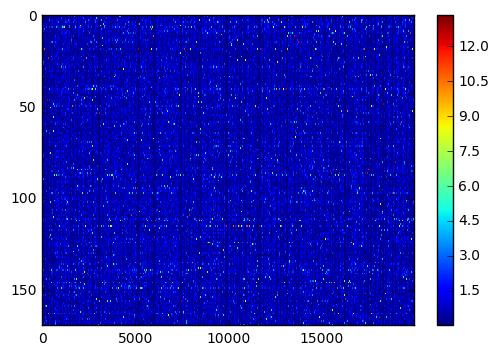

In [32]:
plt.imshow(np.sqrt(np.square(real_set.get_value()-sample_vis_layer)),interpolation='none')
plt.axis('tight')
plt.colorbar()

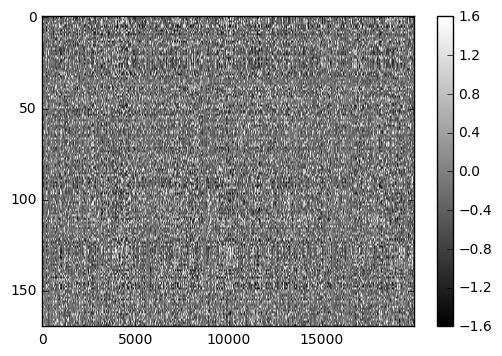

In [46]:
plt.imshow(real_set.get_value(),clim=(-1.6,1.6),cmap='gray')
plt.axis('tight')
plt.colorbar()

In [42]:
c = []
for i in range(170):
    rmse = np.sqrt(np.sum(np.square(real_set.get_value()[i]-sample_vis_layer[2][i])[0]))
    if rmse < 1.5:
        c.append(rmse)
    else:
        print i,rmse

6 2.45707
10 1.6295
16 2.49061
23 1.6375
24 1.81632
31 1.50566
34 2.09487
40 1.93264
44 1.756
45 2.70642
94 2.47482
100 1.64358
102 2.87095
107 1.81132
112 4.1179
124 2.36957
125 1.63484
135 1.68787
137 2.29227
139 2.59013
141 1.77793
149 2.02996
151 1.92353
154 3.29456
163 2.14997
169 1.53931


(array([ 17.,  18.,  18.,  25.,  13.,   9.,  12.,  16.,   7.,   9.]),
 array([ 0.0036194 ,  0.14949374,  0.29536807,  0.44124241,  0.58711675,
         0.73299108,  0.87886542,  1.02473976,  1.17061409,  1.31648843,
         1.46236277]),
 <a list of 10 Patch objects>)

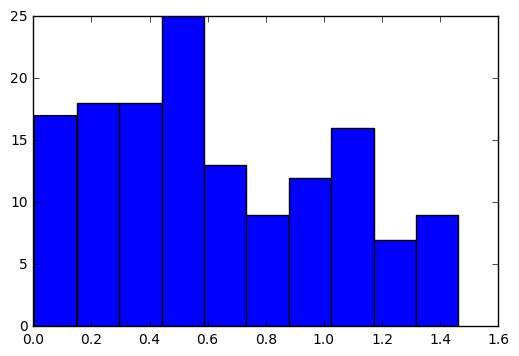

In [43]:
plt.hist(c)

In [44]:
np.mean(c)

0.63045692